
Qwen3-14B-FP8 vs Qwen3-14B-AWQ

In [15]:
import json
import itertools
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt



In [16]:
# Configuration - update path to your data
DATA_DIR = Path("../logs/Qwen3-14B-FP8_flashattn_no_layer_fp8_vs_fraud250_AWQ_2999seqlen_20260104_084758")


In [17]:
# Load config
with open(DATA_DIR / "config.json") as f:
    config = json.load(f)

print(f"Experiment: {DATA_DIR.name}\n")
for k, v in config.items():
    if k != "servers":
        print(f"  {k}: {v}")
print()

# Load data from all servers
data = {}
for f in DATA_DIR.glob("server_*.json"):
    with open(f) as fp:
        d = json.load(fp)
        name = d["server_name"]
        data[name] = {
            "vectors": np.array(d["vectors"]),
            "nonces": d["nonces"],
            "distances": d["distances"],
        }
        print(f"  {name}: {data[name]['vectors'].shape}")

servers = list(data.keys())
print(f"\nLoaded: {servers}")


Experiment: Qwen3-14B-FP8_flashattn_no_layer_fp8_vs_fraud250_AWQ_2999seqlen_20260104_084758

  block_hash: TEST_BLOCK_HsdcASH_123sdcsdc
  public_key: test_nodesdcdcd
  r_target: 1.9337684
  nonce_count: 500
  batch_size: 7
  seq_len: 2999

  server_228: (500, 12)
  server_79: (500, 12)
  server_250: (500, 12)

Loaded: ['server_228', 'server_79', 'server_250']


In [18]:
# Compute pairwise L2 distances for same nonces across servers
pairwise_dists = {}

for s1, s2 in itertools.combinations(servers, 2):
    v1, v2 = data[s1]["vectors"], data[s2]["vectors"]
    dists = np.linalg.norm(v1 - v2, axis=1)
    pairwise_dists[(s1, s2)] = dists

# Pretty print
print("Pairwise L2 distances (same nonce, different servers):\n")
for (s1, s2), dists in pairwise_dists.items():
    n1, n2 = s1.replace("server_", ""), s2.replace("server_", "")
    print(f"  {n1:>8} vs {n2:<8}  {np.mean(dists):.6f} ± {np.std(dists):.6f}  (max {np.max(dists):.4f})")


Pairwise L2 distances (same nonce, different servers):

       228 vs 79        0.049161 ± 0.044788  (max 0.6662)
       228 vs 250       0.279929 ± 0.136324  (max 1.3491)
        79 vs 250       0.279106 ± 0.134116  (max 1.3358)


In [19]:
# Identify cheater: find server that appears in all high-distance pairs
# Auto-detect threshold by finding largest gap in sorted means
pair_means = sorted([(k, np.mean(v)) for k, v in pairwise_dists.items()], key=lambda x: x[1])
gaps = [(pair_means[i+1][1] - pair_means[i][1], i) for i in range(len(pair_means)-1)]
max_gap, gap_idx = max(gaps)
threshold = (pair_means[gap_idx][1] + pair_means[gap_idx+1][1]) / 2

print(f"Auto-detected threshold: {threshold:.6f} (gap: {max_gap:.6f})\n")

high_dist_pairs = [(s1, s2) for (s1, s2), d in pairwise_dists.items() if np.mean(d) > threshold]
low_dist_pairs = [(s1, s2) for (s1, s2), d in pairwise_dists.items() if np.mean(d) <= threshold]

# Count how many high-distance pairs each server appears in
suspect_count = {s: 0 for s in servers}
for s1, s2 in high_dist_pairs:
    suspect_count[s1] += 1
    suspect_count[s2] += 1

print(f"High-distance pairs: {len(high_dist_pairs)}")
print(f"Low-distance pairs:  {len(low_dist_pairs)}\n")

print("Server involvement in high-distance pairs:\n")
for s in sorted(servers, key=lambda x: suspect_count[x], reverse=True):
    name = s.replace("server_", "")
    count = suspect_count[s]
    total = len(high_dist_pairs)
    marker = " ← CHEATER" if count == total and total > 0 else ""
    print(f"  {name:>8}  {count}/{total}{marker}")


Auto-detected threshold: 0.164133 (gap: 0.229945)

High-distance pairs: 2
Low-distance pairs:  1

Server involvement in high-distance pairs:

       250  2/2 ← CHEATER
       228  1/2
        79  1/2


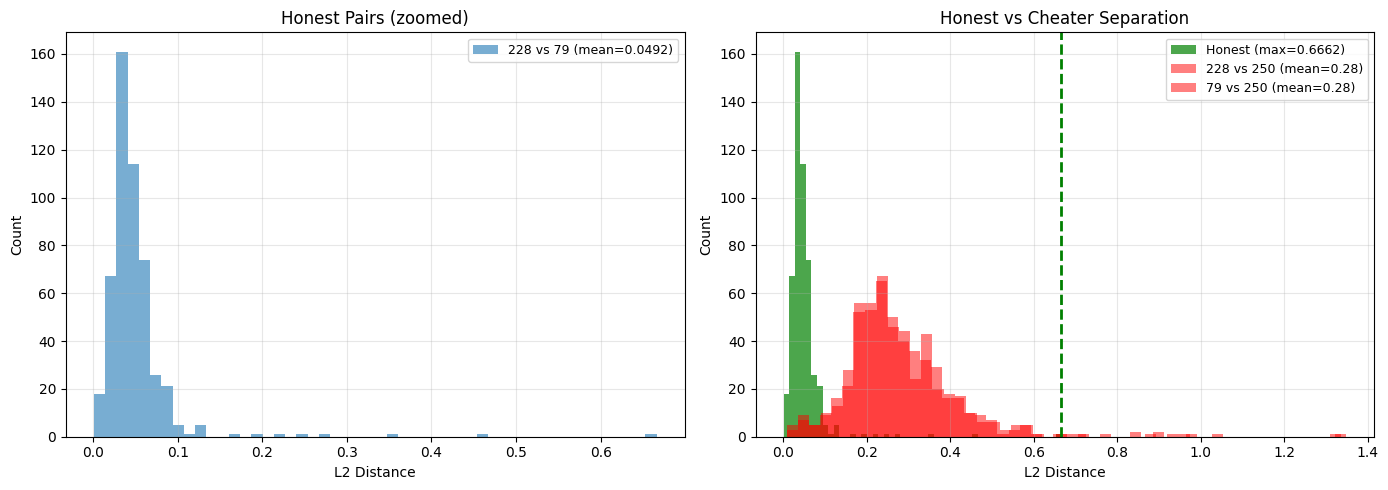


Separation: honest_max=0.6662, cheater_min=0.0090


In [20]:
# Visualization - split honest vs cheater for readability
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Use threshold from cell 5 (already computed)
honest = {k: v for k, v in pairwise_dists.items() if np.mean(v) < threshold}
cheater = {k: v for k, v in pairwise_dists.items() if np.mean(v) >= threshold}

# Left: Honest pairs (zoomed)
ax1 = axes[0]
for (s1, s2), dists in honest.items():
    label = f"{s1.replace('server_','')} vs {s2.replace('server_','')} (mean={np.mean(dists):.4f})"
    ax1.hist(dists, bins=50, alpha=0.6, label=label)
ax1.set_xlabel("L2 Distance")
ax1.set_ylabel("Count")
ax1.set_title("Honest Pairs (zoomed)")
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Right: All pairs showing separation
ax2 = axes[1]
# Plot honest as one combined distribution
all_honest = np.concatenate(list(honest.values()))
ax2.hist(all_honest, bins=50, alpha=0.7, label=f"Honest (max={np.max(all_honest):.4f})", color="green")
# Plot cheater pairs
for (s1, s2), dists in cheater.items():
    label = f"{s1.replace('server_','')} vs {s2.replace('server_','')} (mean={np.mean(dists):.2f})"
    ax2.hist(dists, bins=50, alpha=0.5, label=label, color="red")
ax2.set_xlabel("L2 Distance")
ax2.set_ylabel("Count")
ax2.set_title("Honest vs Cheater Separation")
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.axvline(np.max(all_honest), color="green", linestyle="--", linewidth=2, label="honest max")

plt.tight_layout()
plt.show()

# Print separation margin
print(f"\nSeparation: honest_max={np.max(all_honest):.4f}, cheater_min={min(np.min(v) for v in cheater.values()):.4f}")


In [21]:
from scipy.stats import binomtest

# Statistical fraud detection based on honest pair distribution

# 1. Estimate honest distribution from all honest pairs
all_honest_dists = np.concatenate([pairwise_dists[k] for k in low_dist_pairs])
print(f"Honest distribution (n={len(all_honest_dists)}):")
print(f"  mean:   {np.mean(all_honest_dists):.6f}")
print(f"  std:    {np.std(all_honest_dists):.6f}")
print(f"  median: {np.median(all_honest_dists):.6f}")
print(f"  max:    {np.max(all_honest_dists):.6f}")

# 2. Set threshold at percentile of honest distribution
percentile = 95
dist_threshold = np.percentile(all_honest_dists, percentile)
print(f"\nThreshold at {percentile}th percentile: {dist_threshold:.6f}")

# 3. Estimate false positive rate from honest pairs
fp_count = np.sum(all_honest_dists > dist_threshold)
fp_rate = fp_count / len(all_honest_dists)
print(f"False positive rate on honest: {fp_count}/{len(all_honest_dists)} = {fp_rate:.6f}")


Honest distribution (n=500):
  mean:   0.049161
  std:    0.044788
  median: 0.041359
  max:    0.666156

Threshold at 95th percentile: 0.088702
False positive rate on honest: 25/500 = 0.050000


In [22]:
# 4. Test all pairs using binomial test
# H0: pair is honest (mismatch rate = fp_rate)
# H1: pair has higher mismatch rate (fraud)

fraud_threshold = 0.01  # p-value below this = fraud detected

print(f"Fraud detection (dist_threshold={dist_threshold:.6f}, expected_fp_rate={fp_rate:.6f}):\n")

for (s1, s2), dists in pairwise_dists.items():
    n_total = len(dists)
    n_exceed = np.sum(dists > dist_threshold)
    exceed_rate = n_exceed / n_total
    
    # Binomial test: is exceed rate significantly higher than expected?
    if fp_rate > 0:
        p_value = binomtest(n_exceed, n_total, fp_rate, alternative='greater').pvalue
    else:
        # If fp_rate=0, any exceed is suspicious
        p_value = 0.0 if n_exceed > 0 else 1.0
    
    fraud = p_value < fraud_threshold
    
    n1, n2 = s1.replace("server_", ""), s2.replace("server_", "")
    status = "FRAUD" if fraud else "OK"
    print(f"  {n1:>8} vs {n2:<8}  exceed: {n_exceed:3d}/{n_total} ({exceed_rate*100:5.1f}%)  p={p_value:.2e}  [{status}]")


Fraud detection (dist_threshold=0.088702, expected_fp_rate=0.050000):

       228 vs 79        exceed:  25/500 (  5.0%)  p=5.29e-01  [OK]
       228 vs 250       exceed: 483/500 ( 96.6%)  p=0.00e+00  [FRAUD]
        79 vs 250       exceed: 483/500 ( 96.6%)  p=0.00e+00  [FRAUD]


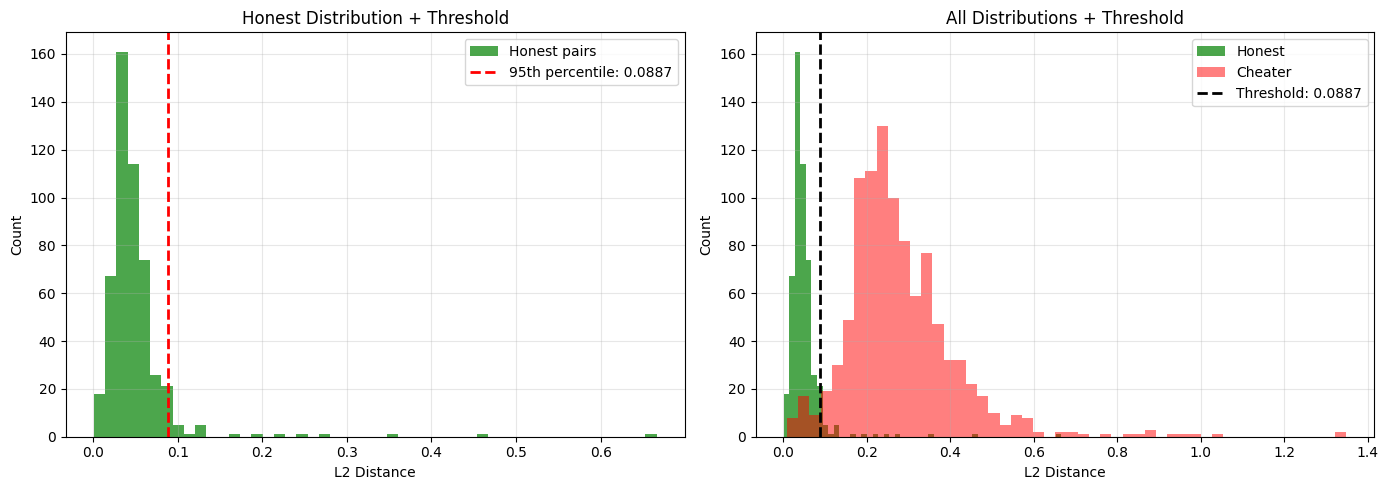


Cheater nonces exceeding threshold: 966/1000 (96.6%)


In [23]:
# 5. Visualize threshold on distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Honest distribution with threshold
ax1 = axes[0]
ax1.hist(all_honest_dists, bins=50, alpha=0.7, color="green", label="Honest pairs")
ax1.axvline(dist_threshold, color="red", linestyle="--", linewidth=2, label=f"{percentile}th percentile: {dist_threshold:.4f}")
ax1.set_xlabel("L2 Distance")
ax1.set_ylabel("Count")
ax1.set_title("Honest Distribution + Threshold")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right: All pairs with threshold
ax2 = axes[1]
ax2.hist(all_honest_dists, bins=50, alpha=0.7, color="green", label="Honest")
all_cheater_dists = np.concatenate([pairwise_dists[k] for k in high_dist_pairs])
ax2.hist(all_cheater_dists, bins=50, alpha=0.5, color="red", label="Cheater")
ax2.axvline(dist_threshold, color="black", linestyle="--", linewidth=2, label=f"Threshold: {dist_threshold:.4f}")
ax2.set_xlabel("L2 Distance")
ax2.set_ylabel("Count")
ax2.set_title("All Distributions + Threshold")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary stats
cheater_exceed = np.sum(all_cheater_dists > dist_threshold)
print(f"\nCheater nonces exceeding threshold: {cheater_exceed}/{len(all_cheater_dists)} ({cheater_exceed/len(all_cheater_dists)*100:.1f}%)")


In [24]:
# ============================================================
# DISTANCE-BASED ANALYSIS (without vectors)
# ============================================================
# Compare reported distances directly - same nonce should give same distance

print("=" * 60)
print("DISTANCE-BASED ANALYSIS")
print("=" * 60)

# Compute pairwise distance differences (|d1 - d2| for same nonce)
pairwise_dist_diff = {}

for s1, s2 in itertools.combinations(servers, 2):
    d1 = np.array(data[s1]["distances"])
    d2 = np.array(data[s2]["distances"])
    diff = np.abs(d1 - d2)
    pairwise_dist_diff[(s1, s2)] = diff

# Pretty print
print("\nPairwise distance differences (|d1 - d2| for same nonce):\n")
for (s1, s2), diff in pairwise_dist_diff.items():
    n1, n2 = s1.replace("server_", ""), s2.replace("server_", "")
    print(f"  {n1:>8} vs {n2:<8}  {np.mean(diff):.6f} ± {np.std(diff):.6f}  (max {np.max(diff):.4f})")


DISTANCE-BASED ANALYSIS

Pairwise distance differences (|d1 - d2| for same nonce):

       228 vs 79        0.008349 ± 0.010631  (max 0.1333)
       228 vs 250       0.049832 ± 0.048128  (max 0.3045)
        79 vs 250       0.049795 ± 0.048907  (max 0.3241)


In [25]:
# Auto-detect threshold and identify cheater (distance-based)
pair_means_d = sorted([(k, np.mean(v)) for k, v in pairwise_dist_diff.items()], key=lambda x: x[1])
gaps_d = [(pair_means_d[i+1][1] - pair_means_d[i][1], i) for i in range(len(pair_means_d)-1)]
max_gap_d, gap_idx_d = max(gaps_d)
threshold_d = (pair_means_d[gap_idx_d][1] + pair_means_d[gap_idx_d+1][1]) / 2

print(f"Auto-detected threshold: {threshold_d:.6f} (gap: {max_gap_d:.6f})\n")

high_dist_pairs_d = [(s1, s2) for (s1, s2), d in pairwise_dist_diff.items() if np.mean(d) > threshold_d]
low_dist_pairs_d = [(s1, s2) for (s1, s2), d in pairwise_dist_diff.items() if np.mean(d) <= threshold_d]

# Count involvement
suspect_count_d = {s: 0 for s in servers}
for s1, s2 in high_dist_pairs_d:
    suspect_count_d[s1] += 1
    suspect_count_d[s2] += 1

print(f"High-diff pairs: {len(high_dist_pairs_d)}")
print(f"Low-diff pairs:  {len(low_dist_pairs_d)}\n")

print("Server involvement in high-diff pairs:\n")
for s in sorted(servers, key=lambda x: suspect_count_d[x], reverse=True):
    name = s.replace("server_", "")
    count = suspect_count_d[s]
    total = len(high_dist_pairs_d)
    marker = " ← CHEATER" if count == total and total > 0 else ""
    print(f"  {name:>8}  {count}/{total}{marker}")


Auto-detected threshold: 0.029072 (gap: 0.041446)

High-diff pairs: 2
Low-diff pairs:  1

Server involvement in high-diff pairs:

       250  2/2 ← CHEATER
       228  1/2
        79  1/2


In [26]:
# Statistical fraud detection (distance-based)
all_honest_diff = np.concatenate([pairwise_dist_diff[k] for k in low_dist_pairs_d])
print(f"Honest diff distribution (n={len(all_honest_diff)}):")
print(f"  mean:   {np.mean(all_honest_diff):.6f}")
print(f"  std:    {np.std(all_honest_diff):.6f}")
print(f"  median: {np.median(all_honest_diff):.6f}")
print(f"  max:    {np.max(all_honest_diff):.6f}")

# Threshold at percentile
percentile_d = 95.0
diff_threshold = np.percentile(all_honest_diff, percentile_d)
print(f"\nThreshold at {percentile_d}th percentile: {diff_threshold:.6f}")

# False positive rate
fp_count_d = np.sum(all_honest_diff > diff_threshold)
fp_rate_d = fp_count_d / len(all_honest_diff)
print(f"False positive rate on honest: {fp_count_d}/{len(all_honest_diff)} = {fp_rate_d:.6f}")


Honest diff distribution (n=500):
  mean:   0.008349
  std:    0.010631
  median: 0.005931
  max:    0.133281

Threshold at 95.0th percentile: 0.023272
False positive rate on honest: 25/500 = 0.050000


In [27]:
# Binomial test for fraud detection (distance-based)
print(f"Fraud detection (diff_threshold={diff_threshold:.6f}, expected_fp_rate={fp_rate_d:.6f}):\n")

for (s1, s2), diff in pairwise_dist_diff.items():
    n_total = len(diff)
    n_exceed = np.sum(diff > diff_threshold)
    exceed_rate = n_exceed / n_total
    
    if fp_rate_d > 0:
        p_value = binomtest(n_exceed, n_total, fp_rate_d, alternative='greater').pvalue
    else:
        p_value = 0.0 if n_exceed > 0 else 1.0
    
    fraud = p_value < 0.01
    
    n1, n2 = s1.replace("server_", ""), s2.replace("server_", "")
    status = "FRAUD" if fraud else "OK"
    print(f"  {n1:>8} vs {n2:<8}  exceed: {n_exceed:3d}/{n_total} ({exceed_rate*100:5.1f}%)  p={p_value:.2e}  [{status}]")


Fraud detection (diff_threshold=0.023272, expected_fp_rate=0.050000):

       228 vs 79        exceed:  25/500 (  5.0%)  p=5.29e-01  [OK]
       228 vs 250       exceed: 313/500 ( 62.6%)  p=5.46e-270  [FRAUD]
        79 vs 250       exceed: 317/500 ( 63.4%)  p=5.00e-276  [FRAUD]


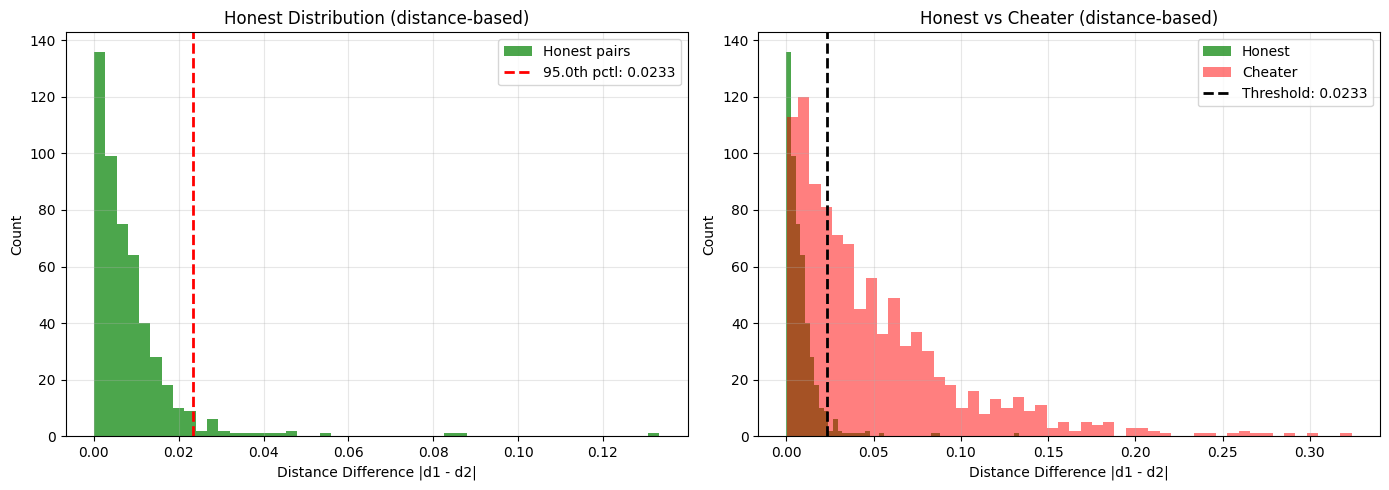


Cheater nonces exceeding threshold: 630/1000 (63.0%)


In [28]:
# Visualization (distance-based)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Honest diff distribution with threshold
ax1 = axes[0]
ax1.hist(all_honest_diff, bins=50, alpha=0.7, color="green", label="Honest pairs")
ax1.axvline(diff_threshold, color="red", linestyle="--", linewidth=2, label=f"{percentile_d}th pctl: {diff_threshold:.4f}")
ax1.set_xlabel("Distance Difference |d1 - d2|")
ax1.set_ylabel("Count")
ax1.set_title("Honest Distribution (distance-based)")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right: All pairs
ax2 = axes[1]
ax2.hist(all_honest_diff, bins=50, alpha=0.7, color="green", label="Honest")
if high_dist_pairs_d:
    all_cheater_diff = np.concatenate([pairwise_dist_diff[k] for k in high_dist_pairs_d])
    ax2.hist(all_cheater_diff, bins=50, alpha=0.5, color="red", label="Cheater")
ax2.axvline(diff_threshold, color="black", linestyle="--", linewidth=2, label=f"Threshold: {diff_threshold:.4f}")
ax2.set_xlabel("Distance Difference |d1 - d2|")
ax2.set_ylabel("Count")
ax2.set_title("Honest vs Cheater (distance-based)")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary
if high_dist_pairs_d:
    cheater_exceed_d = np.sum(all_cheater_diff > diff_threshold)
    print(f"\nCheater nonces exceeding threshold: {cheater_exceed_d}/{len(all_cheater_diff)} ({cheater_exceed_d/len(all_cheater_diff)*100:.1f}%)")
